总节点数: 448
总单元数: 128
节点和单元文件已成功生成: nodes.txt 和 elements.txt


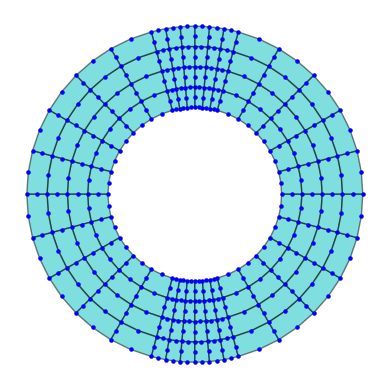

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# 圆环的几何参数
X_origin = 312  # 圆心 X 坐标
Y_origin = 312  # 圆心 Y 坐标
inner_radius = 155  # 内半径
outer_radius = 300  # 外半径
NXE = 4  # 网格在 X 方向的单元数
dhx = (outer_radius - inner_radius) / NXE  # 单元宽度

# 手动设置 Y 方向的单元角度间隔 dhy
# 这里设置一个示例数组，你可以根据需要修改每个单元的角度步长
dhy = np.array([
    15, 15, 15, 15, 15, 5, 5, 5, 
    5, 5, 5, 15, 15, 15, 15, 15,
    15, 15, 15, 15, 15, 5, 5, 5, 
    5, 5, 5, 15, 15, 15, 15, 15,
]) / 360 * 2 * np.pi  # 将角度转换为弧度
NYE = dhy.size  # 网格在 Y 方向的单元数

# 初始化全局变量
geom = []  # 节点坐标
connec = []  # 单元连接关系
nnd = 0  # 全局节点计数器
k = 0  # 全局单元计数器

# 局部函数：检查并创建节点
def check_and_create_node(x, y):
    global nnd, geom
    for nn, (gx, gy) in enumerate(geom):
        if abs(gx - x) < 1e-6 and abs(gy - y) < 1e-6:
            return nn + 1  # 如果存在，返回已有节点编号
    nnd += 1
    geom.append([x, y])  # 如果不存在，创建新节点
    return nnd

# 计算节点和单元连接
for i in range(1, NXE + 1):
    for j in range(1, NYE + 1):
        k += 1  # 单元计数器

        # 节点编号规则
        r1 = inner_radius + (i - 1) * dhx  # 当前单元的内半径
        r2 = inner_radius + i * dhx  # 当前单元的外半径

        # 使用手动设置的 dhy 数组计算当前单元的起始和结束角度
        theta1 = np.sum(dhy[:j-1])  # 当前单元的起始角度
        theta2 = np.sum(dhy[:j])  # 当前单元的结束角度
        theta_mid = (theta1 + theta2) / 2  # 圆弧的中间角度

        # 修正角度，避免 360°（2*pi）重复
        if abs(theta1 - 2 * np.pi) < 1e-6:
            theta1 = 0
        if abs(theta2 - 2 * np.pi) < 1e-6:
            theta2 = 0
        if abs(theta_mid - 2 * np.pi) < 1e-6:
            theta_mid = 0

        # 检查并创建节点
        # 创建Q8单元的4个角点
        n1 = check_and_create_node(r1 * np.cos(theta1) + X_origin, r1 * np.sin(theta1) + Y_origin)
        n3 = check_and_create_node(r2 * np.cos(theta1) + X_origin, r2 * np.sin(theta1) + Y_origin)
        n5 = check_and_create_node(r2 * np.cos(theta2) + X_origin, r2 * np.sin(theta2) + Y_origin)
        n7 = check_and_create_node(r1 * np.cos(theta2) + X_origin, r1 * np.sin(theta2) + Y_origin)
        
        # 创建Q8单元的4个中间点
        n2 = check_and_create_node((geom[n1 - 1][0] + geom[n3 - 1][0]) / 2, (geom[n1 - 1][1] + geom[n3 - 1][1]) / 2)
        n4 = check_and_create_node(r2 * np.cos(theta_mid) + X_origin, r2 * np.sin(theta_mid) + Y_origin)
        n6 = check_and_create_node((geom[n5 - 1][0] + geom[n7 - 1][0]) / 2, (geom[n5 - 1][1] + geom[n7 - 1][1]) / 2)
        n8 = check_and_create_node(r1 * np.cos(theta_mid) + X_origin, r1 * np.sin(theta_mid) + Y_origin)

        # 生成单元连接关系
        connec.append([n1, n2, n3, n4, n5, n6, n7, n8])

# 输出结果检查
print(f'总节点数: {nnd}')
print(f'总单元数: {k}')

# 节点和单元文件写入
node_file = 'nodes.txt'  # 节点文件
element_file = 'elements.txt'  # 单元文件

# 写入节点文件
with open(node_file, 'w') as fid_nodes:
    for i, (x, y) in enumerate(geom, start=1):
        fid_nodes.write(f'{i}, {x:.6f}, {y:.6f}\n')

# 写入单元文件
with open(element_file, 'w') as fid_elements:
    for i, conn in enumerate(connec, start=1):
        conn = [conn[idx - 1] for idx in [1, 3, 5, 7, 2, 4, 6, 8]]
        fid_elements.write(f'{i}, ' + ', '.join(map(str, conn)) + '\n')

print('节点和单元文件已成功生成: nodes.txt 和 elements.txt')

# 绘制圆环网格模型
geom = np.array(geom)
connec = np.array(connec) - 1  # 转换为零索引
plt.figure('圆环Q8单元有限元网格模型')
plt.gca().set_aspect('equal', adjustable='box')
for elem in connec:
    plt.fill(geom[elem, 0], geom[elem, 1], edgecolor='k', facecolor='c', alpha=0.5)

# 显示节点编号
for i, (x, y) in enumerate(geom, start=1):
    plt.scatter(x, y, color='blue', s=5)  # 绘制节点

    # plt.text(x, y, str(i), fontsize=6, color='blue')

# # 显示单元编号
# for j, elem in enumerate(connec, start=1):
#     center_x = np.mean(geom[elem, 0])
#     center_y = np.mean(geom[elem, 1])
#     plt.text(center_x, center_y, str(j), fontsize=6, color='red', fontweight='bold')

plt.axis('off')
plt.show()


In [44]:
def get_integer_points_of_element(nodes, center):
    """
    输入: nodes 为一个 8x2 矩阵, 表示单元的8个节点坐标 (x, y)
    输出：返回一个 Nx2 矩阵，包含所有整数坐标点
    8个节点的顺序为:
    逆时针方向: 首先4个角点, 其次四个中间点
    """
    
    # 提取节点的 x 和 y 坐标
    x_coords = nodes[:, 0]
    y_coords = nodes[:, 1]
    center_x, center_y = center

    # 计算内外半径
    inner_radius = np.min(np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2))  # 内半径
    outer_radius = np.max(np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2))  # 外半径
    # 计算左右边界角度
    angle_nodes = np.arctan2(y_coords - center_y, x_coords - center_x)  # 计算每个节点的角度
    # 将角度转换到 [0, 2*pi] 范围内
    angle_nodes[angle_nodes < 0] += 2 * np.pi
    left_angle =  np.min(angle_nodes)  # 左边界角度
    right_angle = np.max(angle_nodes)  # 右边界角度
    flag = 0  # 标志变量，判断是否跨越 0 度线, 0表示没有跨越，1表示跨越
    if right_angle - left_angle > np.pi:
        # 如果左边界角度大于右边界角度，说明跨越了 0 度线，需要调整
        flag = 1
        left_angle  = np.min(np.arctan2(y_coords - center_y, x_coords - center_x))
        right_angle = np.max(np.arctan2(y_coords - center_y, x_coords - center_x))

    # print(f'左边界角度: {left_angle}, 右边界角度: {right_angle}')

    # 确定单元的最小和最大 x，y 坐标范围
    min_x = np.floor(np.min(x_coords))
    max_x = np.ceil(np.max(x_coords))
    min_y = np.floor(np.min(y_coords))
    max_y = np.ceil(np.max(y_coords))

    # 生成单元内的网格（通过网格化 x 和 y 方向的坐标）
    x_grid, y_grid = np.meshgrid(np.arange(min_x, max_x + 1), np.arange(min_y, max_y + 1))
    grid_points = np.vstack((x_grid.ravel(), y_grid.ravel())).T  # 转换为 Nx2 矩阵
    radius = np.sqrt((grid_points[:, 0] - center_x)**2 + (grid_points[:, 1] - center_y)**2)  # 计算每个点到圆心的距离
    angles = np.arctan2(grid_points[:, 1] - center_y, grid_points[:, 0] - center_x)  # 计算每个点的角度
    # 将角度转换到 [0, 2*pi] 范围内
    if flag == 0:
        angles[angles < 0] += 2 * np.pi
    # 过滤出在圆环内的整数点
    valid_points = np.logical_and(radius >= inner_radius, radius <= outer_radius)  # 在圆环内的点
    angle_valid = np.logical_and(angles >= left_angle, angles <= right_angle)  # 在角度范围内的点
    valid_points = np.logical_and(valid_points, angle_valid)  # 综合条件
    integer_points = grid_points[valid_points]  # 获取符合条件的整数点坐标
    return np.array(integer_points)


In [46]:
r1 = inner_radius   # 内半径
r2 = outer_radius   # 外半径
Cx = X_origin       # 图像中心X坐标
Cy = Y_origin       # 图像中心Y坐标
d1 = 625           # 图像宽度
d2 = 625           # 图像高度

# 读取节点和单元数据
node = np.loadtxt('nodes.txt', delimiter=',')  # 第一列为节点，第二列和第三列为坐标，单位是像素
element = np.loadtxt('elements.txt', delimiter=',', dtype=int)  # 第一列为单元编号，后边8列为该单元的节点
node_num = node.shape[0]  # 节点数量
element_num = element.shape[0]  # 单元数量

# 用于存储像素点和单元的关系
Inform = []
# 遍历所有单元中的像素点
for i in range(element_num):
    # 获取单元的节点坐标
    nodes = node[element[i, 1:]-1, 1:3]  # 获取该单元的8个节点坐标
    # 获取该单元内的整数点
    integer_points = get_integer_points_of_element(nodes, center=[Cx, Cy])
    # 将整数点和单元编号存储到 Inform 中
    for point in integer_points:
        Inform.append([point[0], point[1], i + 1])  # 注意单元编号从1开始
# 将 Inform 转换为 NumPy 数组
Inform = np.array(Inform)
# 保存 Inform 到 .npy 文件
np.save('Inform.npy', Inform)


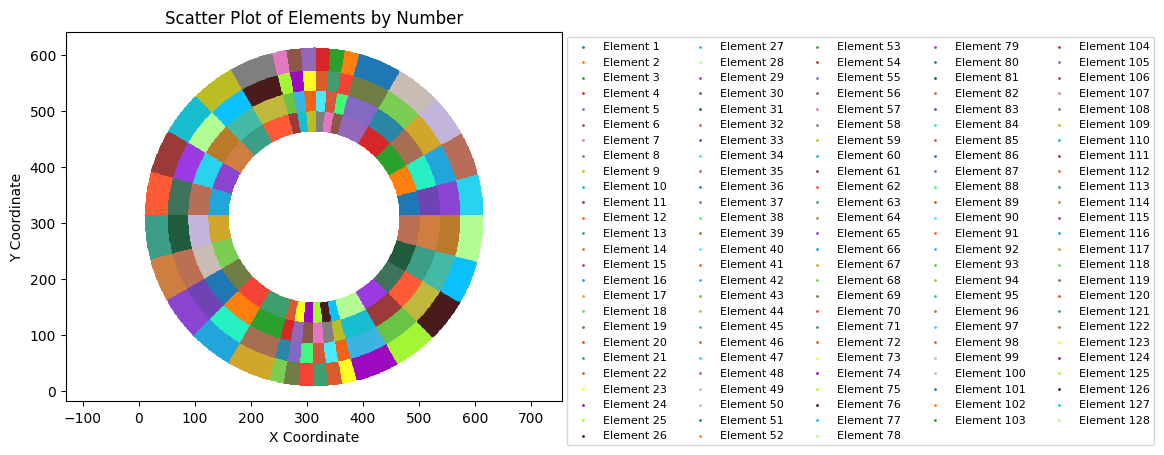

In [47]:
# 加载数据
Inform = np.load('Inform.npy')  # 读取 .npy 文件

# 初始化一个列表来存储不同编号的元素
numElements = int(np.max(Inform[:, 2]))  # 找到最大的单元编号
elements = [[] for _ in range(numElements)]  # 初始化一个空的列表，大小为 numElements

# 遍历 Inform 数组，将元素按编号存储到列表中
for row in Inform:
    num = int(row[2])  # 获取当前元素的编号
    elements[num - 1].append(row[:2])  # 存储元素（注意：这里我们也将编号存储了，以便后续使用）

fixed_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#9c3a3a", "#ff5a36", "#3d9e87", "#cf7e42", "#8a44d0", "#22a5db", "#d0a62b", "#7bce51", "#6e7e45", "#f44336",
    "#3e9e6d", "#d85c2d", "#fdfc23", "#9c09be", "#a3f636", "#491b1b", "#0ac1fe", "#b3fc93", "#9b39e3", "#3f725b",
    "#1f5b3c", "#bc6f53", "#6e44b5", "#25f1c2", "#a66f53", "#2986a5", "#8269c3", "#45f779", "#d45839", "#49e9fe",
    "#f46216", "#3ab4e1", "#69c347", "#c0b73d", "#44bba7", "#bb7a29", "#28d3ef", "#b76d57", "#c3b4db", "#c8bcb4"
]

# 绘制散点图
plt.figure()
colors = plt.cm.viridis(np.linspace(0, 1, numElements))  # 获取一个颜色数组，用于不同编号的元素
for num in range(numElements):
    if len(elements[num]) > 0:  # 检查该编号的元素是否存在
        elements_num = np.array(elements[num])  # 转换为 NumPy 数组
        color_idx = num % len(fixed_colors)
        plt.scatter(elements_num[:, 0], elements_num[:, 1], s=1, c=[fixed_colors[color_idx]], label=f'Element {num + 1}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Elements by Number')
plt.xlim(0,1280); plt.ylim(0,1280)
plt.axis('equal')  # 确保坐标轴比例一致
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=5, fontsize=8)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_everything(42)

class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(2)
        self.fc1 = nn.Linear(2, 64)  # 输入层（全局坐标x, y）
        self.fc2 = nn.Linear(64, 64) # 隐藏层
        self.fc3 = nn.Linear(64, 2)  # 输出层（局部坐标xi, eta）
        self.MSE = nn.MSELoss()  # 均方误差损失函数

    def forward(self, x_global, node_x_coords):
        if x_global.device != device:
            x_global = x_global.to(device)
        if node_x_coords.device != device:
            node_x_coords = node_x_coords.to(device)

        # 先通过归一化层
        x = self.bn1(x_global)
        # 然后通过全连接层和激活函数
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x_local = self.fc3(x)

        N = self.shapef(x_local[:, 0], x_local[:, 1])  # 计算形状函数
        xp_gloabl = torch.matmul(N, node_x_coords)  # 计算预测全局坐标

        # 计算误差
        mse = self.MSE(xp_gloabl, x_global)
        return mse, x_local
        
    def shapef(self, xi, eta):
        N = torch.zeros(xi.shape[0], 8).to(device)
        N[:, 0] = (1 - xi) * (1 - eta) * (-xi - eta - 1) / 4
        N[:, 1] = (1 - xi ** 2) * (1 - eta) / 2
        N[:, 2] = (1 + xi) * (1 - eta) * (xi - eta - 1) / 4
        N[:, 3] = (1 - eta ** 2) * (1 + xi) / 2
        N[:, 4] = (1 + xi) * (1 + eta) * (xi + eta - 1) / 4
        N[:, 5] = (1 - xi ** 2) * (1 + eta) / 2
        N[:, 6] = (1 - xi) * (1 + eta) * (-xi + eta - 1) / 4
        N[:, 7] = (1 - eta ** 2) * (1 - xi) / 2
        return N
    
    def predict(self, x_global, node_x_coords):
        with torch.no_grad():
            if x_global.device != device:
                x_global = x_global.to(device)
            if node_x_coords.device != device:
                node_x_coords = node_x_coords.to(device)
            # 预测局部坐标
            x_local = self.forward(x_global, node_x_coords)[1]
            return x_local.cpu().numpy()
        

node = np.loadtxt('nodes.txt', delimiter=',')
element = np.loadtxt('elements.txt', delimiter=',', dtype=int)
Inform = np.load('Inform.npy')  # 读取 .npy 文件

# 提取单元的节点坐标
ele_all = element[:, 1:]  # 获取每个单元的8个节点
coor_x = np.column_stack([node[ele_all[:, 0]-1, 1],   node[ele_all[:, 4]-1, 1], node[ele_all[:, 1]-1, 1], # -1操作是因为Python的索引从0开始
                            node[ele_all[:, 5]-1, 1], node[ele_all[:, 2]-1, 1], node[ele_all[:, 6]-1, 1], 
                            node[ele_all[:, 3]-1, 1], node[ele_all[:, 7]-1, 1]])
coor_y = np.column_stack([node[ele_all[:, 0]-1, 2],   node[ele_all[:, 4]-1, 2], node[ele_all[:, 1]-1, 2],
                            node[ele_all[:, 5]-1, 2], node[ele_all[:, 2]-1, 2], node[ele_all[:, 6]-1, 2], 
                            node[ele_all[:, 3]-1, 2], node[ele_all[:, 7]-1, 2]])


node_num = node.shape[0]  # 节点数量
element_num = element.shape[0]  # 单元数量

model = NNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Inform_global_local = np.zeros((Inform.shape[0], 5))  # 初始化一个数组，用于存储全局坐标和局部坐标
for i in range(0,1): # element_num
    Ele_i = Inform[Inform[:, 2] == i+1, :2]  # 获取当前单元内的所有像素点
    x_global = torch.tensor(Ele_i, dtype=torch.float32).to(device)  # 当前单元内的所有像素点的全局x坐标
    Ele_x = coor_x[i, :]; Ele_y = coor_y[i, :]  # 当前单元的8个节点的x坐标
    Ele_coords = np.column_stack((Ele_x, Ele_y))  
    node_x_coords = torch.tensor(Ele_coords, dtype=torch.float32).to(device)  # 当前单元的8个节点的坐标

    # 开始迭代训练
    print(f"第{i+1:02d}个单元开始训练")
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        loss, _ = model(x_global, node_x_coords)
        # print(loss.shape)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item()}")
    
    # 预测局部坐标
    model.eval()
    x_local = model.predict(x_global, node_x_coords)
    # 将全局坐标和局部坐标存储到数组中
    Inform_global_local[Inform[:, 2] == i+1, 0:2] = Ele_i
    Inform_global_local[Inform[:, 2] == i+1, 2:4] = x_local
    Inform_global_local[Inform[:, 2] == i+1, 4] = i + 1

# 将结果保存到文件
np.save('Inform_global_local_NN.npy', Inform_global_local)

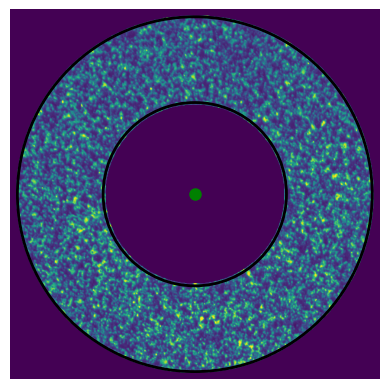

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def display_image_with_circles(image_path, center, inner_radius, outer_radius):
    """
    显示图像并在图像上绘制内外圆圈和圆心。

    参数:
    - image_path: 图像文件路径
    - center: 圆心坐标 (x, y)
    - inner_radius: 内圆半径
    - outer_radius: 外圆半径
    """
    # 打开图像
    image = Image.open(image_path)
    
    # 创建绘图窗口
    fig, ax = plt.subplots()
    
    # 显示图像
    ax.imshow(image)
    
    # 添加内外圆圈
    circle_inner = patches.Circle(center, inner_radius, color='k', fill=False, linewidth=2, label='Inner Circle')
    circle_outer = patches.Circle(center, outer_radius, color='k', fill=False, linewidth=2, label='Outer Circle')
    ax.add_patch(circle_inner)
    ax.add_patch(circle_outer)
    
    # 添加圆心
    ax.plot(center[0], center[1], 'go', markersize=8, label='Center')  # 绿色圆点表示圆心
    
    # 添加图例
    # ax.legend()
    
    # 显示绘图
    plt.axis('off')  # 关闭坐标轴
    plt.show()

# 示例参数
image_path = '0000.bmp'  # 图像路径
center = (312, 312)      # 圆心坐标 (x, y)
inner_radius = 155        # 内圆半径
outer_radius = 300        # 外圆半径

# 调用函数
display_image_with_circles(image_path, center, inner_radius, outer_radius)

In [2]:
import cv2
import numpy as np

# 图像路径
image_path = '0000.bmp'

# 圆心坐标和半径
center = (312, 312)  # 圆心坐标 (x, y)
inner_radius = 155   # 内圆半径
outer_radius = 300   # 外圆半径

# 读取灰度图像
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

H,L = image.shape  # 获取图像的高度和宽度
print(f'图像的高度: {H}, 宽度: {L}')

# 创建一个与图像相同大小的掩膜
mask = np.zeros((H, L), dtype=np.uint8)

x = np.arange(0, L)
y = np.arange(0, H)
X, Y = np.meshgrid(x, y)  # 创建网格坐标矩阵
mask_inner = (X - center[0])**2 + (Y - center[1])**2 >= inner_radius**2  # 内圆掩膜
mask_outer = (X - center[0])**2 + (Y - center[1])**2 <= outer_radius**2  # 外圆掩膜

mask[mask_inner & mask_outer] = 255  # 设置掩膜区域为255（白色）

# 保存掩膜图像
cv2.imwrite('0002.bmp', mask)




图像的高度: 625, 宽度: 625


True

In [7]:
image.shape

(625, 625)